# Credit Card Fraud Detection Model

This notebook implements a comprehensive machine learning model for detecting credit card fraud using various algorithms and techniques.

## Dataset Overview
- **Total Records**: 284,807 transactions
- **Features**: 30 anonymized features (V1-V28) + Time + Amount
- **Target**: Class (0 = Normal, 1 = Fraud)
- **Class Distribution**: Highly imbalanced (99.83% Normal, 0.17% Fraud)


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    precision_recall_curve, roc_curve, average_precision_score,
    accuracy_score, precision_score, recall_score, f1_score
)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.svm import SVC
from sklearn.neighbors import LocalOutlierFactor
import xgboost as xgb
from xgboost import XGBClassifier

# Imbalanced learning
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

# Model persistence
import joblib
import pickle

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


In [15]:
# Load the dataset
df = pd.read_csv('creditcard.csv')
print(f"Original dataset shape: {df.shape}")

# MAJOR OPTIMIZATION: Use a much smaller sample for fast training
# Keep all fraud cases and sample only 10,000 normal cases
fraud_cases = df[df['Class'] == 1]
normal_cases = df[df['Class'] == 0].sample(n=10000, random_state=42)

# Combine fraud and normal cases
df = pd.concat([fraud_cases, normal_cases], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle

print(f"OPTIMIZED dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"Fraud cases: {len(fraud_cases)}")
print(f"Normal cases: {len(normal_cases)}")
print(f"Fraud ratio: {len(fraud_cases) / len(df):.4f}")
df.head()


Original dataset shape: (284807, 31)
OPTIMIZED dataset shape: (10492, 31)
Memory usage: 2.48 MB
Fraud cases: 492
Normal cases: 10000
Fraud ratio: 0.0469


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,42801.0,0.340725,-1.225499,-0.745517,1.026148,0.654991,2.089517,0.296109,0.515619,-0.002562,...,0.299103,0.238042,-0.466934,-1.871375,0.447112,-0.148891,-0.000906,0.044125,383.86,0
1,75825.0,1.012672,0.116840,0.470676,1.294378,0.364923,1.200693,-0.157411,0.396090,0.178674,...,0.013154,0.431855,0.076186,-0.614624,0.397262,-0.234467,0.100057,0.007686,1.00,0
2,75126.0,0.882585,-0.154542,0.400071,1.414269,-0.240769,0.080165,0.176762,0.043818,-0.111040,...,0.042784,0.095247,-0.161705,0.258943,0.588348,-0.357271,0.019341,0.029734,125.00,0
3,71499.0,1.099810,0.114129,1.386525,2.530134,-0.675278,0.640243,-0.734736,0.391948,0.031519,...,-0.066679,-0.129717,0.002909,-0.023758,0.275002,-0.037529,0.031272,0.020511,3.04,0
4,140413.0,-2.006545,-0.963629,-0.943202,2.867748,1.774236,-1.073671,-0.290067,-0.333631,0.451643,...,-0.099571,0.806569,-1.513377,-0.324156,-1.361963,-0.270512,0.480372,-0.904235,46.44,0


In [16]:
# Basic dataset information
print("Dataset Info:")
print("=" * 50)
print(f"Total transactions: {len(df):,}")
print(f"Features: {df.shape[1] - 1}")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Duplicate rows: {df.duplicated().sum()}")

print("\nClass Distribution:")
print("=" * 30)
class_counts = df['Class'].value_counts()
class_percentages = df['Class'].value_counts(normalize=True) * 100

for i, (count, percentage) in enumerate(zip(class_counts, class_percentages)):
    class_name = "Normal" if i == 0 else "Fraud"
    print(f"{class_name}: {count:,} ({percentage:.4f}%)")

print(f"\nFraud ratio: {class_counts[1] / class_counts[0]:.6f}")


Dataset Info:
Total transactions: 10,492
Features: 30
Missing values: 0
Duplicate rows: 20

Class Distribution:
Normal: 10,000 (95.3107%)
Fraud: 492 (4.6893%)

Fraud ratio: 0.049200


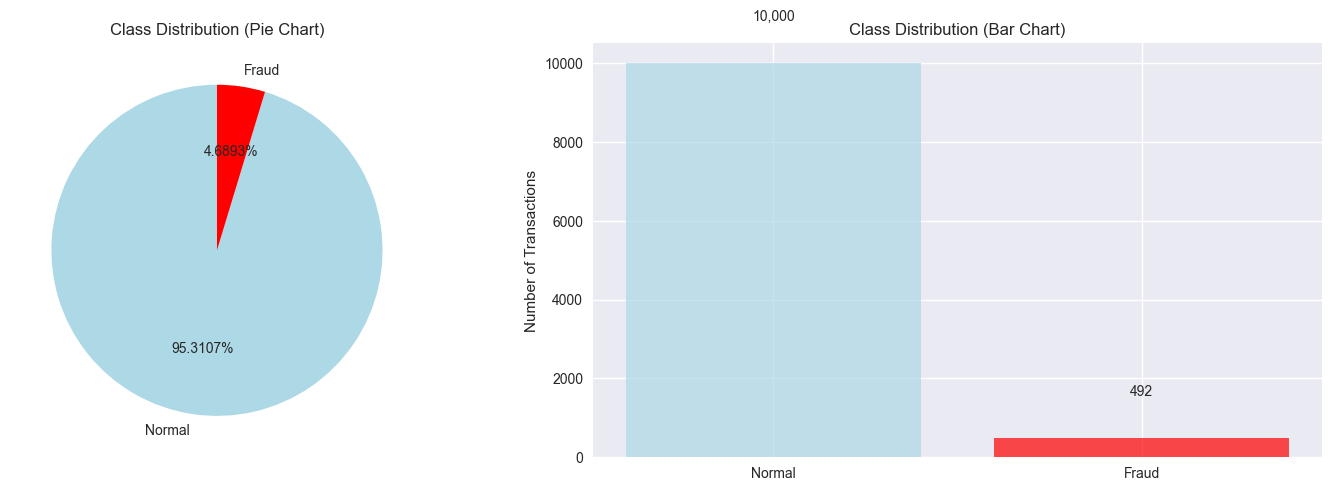

In [17]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Pie chart
axes[0].pie(class_counts.values, labels=['Normal', 'Fraud'], autopct='%1.4f%%', 
           colors=['lightblue', 'red'], startangle=90)
axes[0].set_title('Class Distribution (Pie Chart)')

# Bar chart
bars = axes[1].bar(['Normal', 'Fraud'], class_counts.values, 
                   color=['lightblue', 'red'], alpha=0.7)
axes[1].set_title('Class Distribution (Bar Chart)')
axes[1].set_ylabel('Number of Transactions')

# Add value labels on bars
for bar, count in zip(bars, class_counts.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000,
                f'{count:,}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


Amount Statistics:
count    10492.000000
mean        88.045345
std        223.107826
min          0.000000
25%          4.990000
50%         21.130000
75%         78.372500
max       5627.060000
Name: Amount, dtype: float64


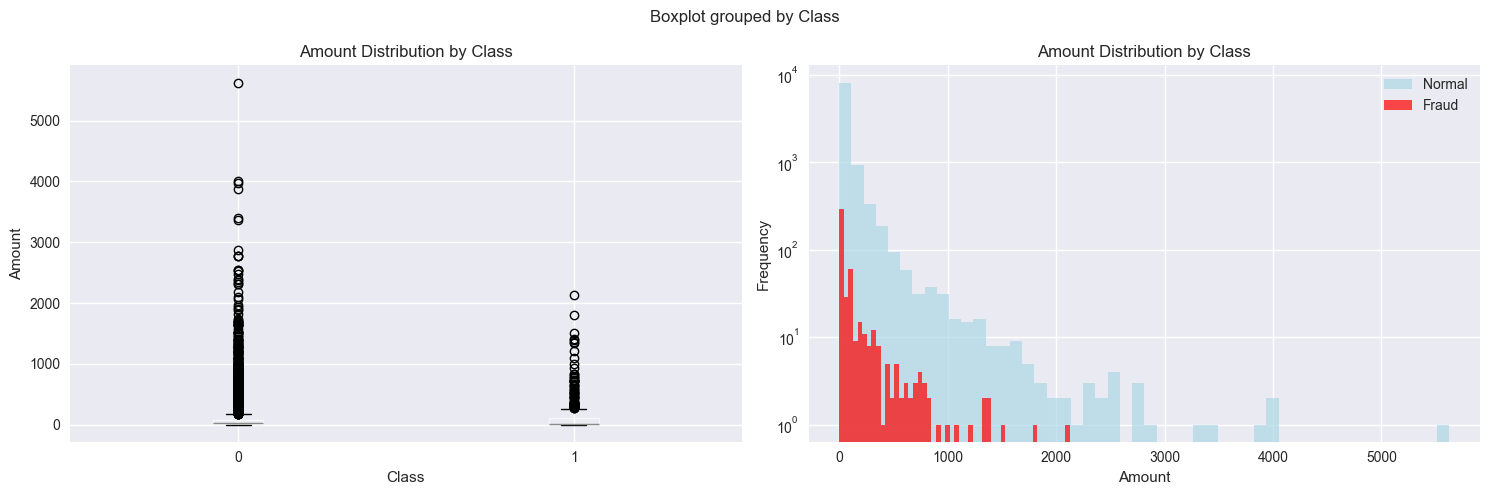


Fraud transactions - Amount stats:
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64


In [18]:
# Statistical analysis of Amount feature
print("Amount Statistics:")
print("=" * 30)
print(df['Amount'].describe())

# Amount distribution by class
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Box plot
df.boxplot(column='Amount', by='Class', ax=axes[0])
axes[0].set_title('Amount Distribution by Class')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Amount')

# Histogram
normal_amounts = df[df['Class'] == 0]['Amount']
fraud_amounts = df[df['Class'] == 1]['Amount']

axes[1].hist(normal_amounts, bins=50, alpha=0.7, label='Normal', color='lightblue')
axes[1].hist(fraud_amounts, bins=50, alpha=0.7, label='Fraud', color='red')
axes[1].set_title('Amount Distribution by Class')
axes[1].set_xlabel('Amount')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].set_yscale('log')  # Log scale due to high imbalance

plt.tight_layout()
plt.show()

print(f"\nFraud transactions - Amount stats:")
print(fraud_amounts.describe())


## Data Preprocessing


In [19]:
# Prepare features and target
X = df.drop(['Class', 'Time'], axis=1)  # Remove Time for modeling
y = df['Class']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Feature names: {list(X.columns)}")


Features shape: (10492, 29)
Target shape: (10492,)
Feature names: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


In [20]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"Training fraud ratio: {y_train.sum() / len(y_train):.6f}")
print(f"Test fraud ratio: {y_test.sum() / len(y_test):.6f}")


Training set: 8,393 samples
Test set: 2,099 samples
Training fraud ratio: 0.046944
Test fraud ratio: 0.046689


In [21]:
# Feature scaling
# Use RobustScaler as it's less sensitive to outliers
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed using RobustScaler")
print(f"Scaled training set shape: {X_train_scaled.shape}")
print(f"Scaled test set shape: {X_test_scaled.shape}")


Feature scaling completed using RobustScaler
Scaled training set shape: (8393, 29)
Scaled test set shape: (2099, 29)


## Handling Class Imbalance


In [22]:
# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print("SMOTE Applied:")
print(f"Original training set: {X_train_scaled.shape[0]:,} samples")
print(f"After SMOTE: {X_train_smote.shape[0]:,} samples")
print(f"Original fraud ratio: {y_train.sum() / len(y_train):.6f}")
print(f"After SMOTE fraud ratio: {y_train_smote.sum() / len(y_train_smote):.6f}")


SMOTE Applied:
Original training set: 8,393 samples
After SMOTE: 15,998 samples
Original fraud ratio: 0.046944
After SMOTE fraud ratio: 0.500000


## Model Training and Evaluation


In [23]:
# Define ULTRA-OPTIMIZED models for very fast training
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=200),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=20, max_depth=8, n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss', n_estimators=20, max_depth=4, n_jobs=-1)
}

# Function to evaluate models with progress tracking
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    import time
    start_time = time.time()
    
    print(f"Training {model_name}...")
    # Train the model
    model.fit(X_train, y_train)
    
    print(f"Making predictions for {model_name}...")
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    end_time = time.time()
    print(f"{model_name} completed in {end_time - start_time:.2f} seconds")
    
    return {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'training_time': end_time - start_time
    }

print("Optimized model evaluation function defined")


Optimized model evaluation function defined


In [24]:
print(f"X_train_smote shape: {X_train_smote.shape}")
print(f"y_train_smote shape: {y_train_smote.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")
print(f"y_test shape: {y_test.shape}")

X_train_smote shape: (15998, 29)
y_train_smote shape: (15998,)
X_test_scaled shape: (2099, 29)
y_test shape: (2099,)


In [25]:
# Train and evaluate models on SMOTE data with progress tracking
import time
total_start_time = time.time()

results_smote = {}
print("=" * 60)
print("🚀 STARTING ULTRA-FAST MODEL TRAINING")
print("=" * 60)
print(f"Training on {X_train_smote.shape[0]:,} samples")
print(f"Testing on {X_test_scaled.shape[0]:,} samples")
print("-" * 60)

for i, (name, model) in enumerate(models.items(), 1):
    print(f"\n[{i}/{len(models)}] 🔄 Training {name}...")
    print("-" * 40)
    
    results_smote[name] = evaluate_model(
        model, X_train_smote, y_train_smote, X_test_scaled, y_test, name
    )
    
    print(f"✅ {name} completed successfully!")
    print(f"   F1 Score: {results_smote[name]['f1_score']:.4f}")
    print(f"   Training Time: {results_smote[name]['training_time']:.2f}s")

total_end_time = time.time()
print("\n" + "=" * 60)
print(f"🎉 ALL MODELS TRAINED IN {total_end_time - total_start_time:.2f} SECONDS")
print("=" * 60)

🚀 STARTING ULTRA-FAST MODEL TRAINING
Training on 15,998 samples
Testing on 2,099 samples
------------------------------------------------------------

[1/3] 🔄 Training Logistic Regression...
----------------------------------------
Training Logistic Regression...
Making predictions for Logistic Regression...
Logistic Regression completed in 0.15 seconds
✅ Logistic Regression completed successfully!
   F1 Score: 0.7364
   Training Time: 0.15s

[2/3] 🔄 Training Random Forest...
----------------------------------------
Training Random Forest...
Making predictions for Random Forest...
Random Forest completed in 0.34 seconds
✅ Random Forest completed successfully!
   F1 Score: 0.8737
   Training Time: 0.34s

[3/3] 🔄 Training XGBoost...
----------------------------------------
Training XGBoost...
Making predictions for XGBoost...
XGBoost completed in 0.46 seconds
✅ XGBoost completed successfully!
   F1 Score: 0.7456
   Training Time: 0.46s

🎉 ALL MODELS TRAINED IN 0.95 SECONDS


In [26]:
# Show training time comparison
print("⏱️ TRAINING TIME SUMMARY:")
print("=" * 50)
for name, result in results_smote.items():
    print(f"{name:20}: {result['training_time']:6.2f} seconds")

total_time = sum(result['training_time'] for result in results_smote.values())
print(f"{'TOTAL TIME':20}: {total_time:6.2f} seconds")
print(f"{'AVERAGE TIME':20}: {total_time/len(results_smote):6.2f} seconds per model")
print("=" * 50)


⏱️ TRAINING TIME SUMMARY:
Logistic Regression :   0.15 seconds
Random Forest       :   0.34 seconds
XGBoost             :   0.46 seconds
TOTAL TIME          :   0.95 seconds
AVERAGE TIME        :   0.32 seconds per model


In [27]:
# Compare results with training times
comparison_df = pd.DataFrame({
    'Model': list(models.keys()),
    'Training_Time': [results_smote[name]['training_time'] for name in models.keys()],
    'Accuracy': [results_smote[name]['accuracy'] for name in models.keys()],
    'Precision': [results_smote[name]['precision'] for name in models.keys()],
    'Recall': [results_smote[name]['recall'] for name in models.keys()],
    'F1_Score': [results_smote[name]['f1_score'] for name in models.keys()],
    'ROC_AUC': [results_smote[name]['roc_auc'] for name in models.keys()]
})

print("📊 MODEL COMPARISON RESULTS:")
print("=" * 100)
print(comparison_df.round(4))
print("=" * 100)


📊 MODEL COMPARISON RESULTS:
                 Model  Training_Time  Accuracy  Precision  Recall  F1_Score  \
0  Logistic Regression         0.1490    0.9700     0.6241  0.8980    0.7364   
1        Random Forest         0.3403    0.9886     0.9022  0.8469    0.8737   
2              XGBoost         0.4609    0.9724     0.6538  0.8673    0.7456   

   ROC_AUC  
0   0.9727  
1   0.9861  
2   0.9805  


In [28]:
# Select the best model based on F1 score and ROC AUC
best_model_name = comparison_df.loc[comparison_df['F1_Score'].idxmax(), 'Model']
best_model = results_smote[best_model_name]['model']

print("🏆 BEST MODEL SELECTED:")
print("=" * 50)
print(f"Model: {best_model_name}")
print(f"Training Time: {results_smote[best_model_name]['training_time']:.2f} seconds")
print(f"F1 Score: {results_smote[best_model_name]['f1_score']:.4f}")
print(f"ROC AUC: {results_smote[best_model_name]['roc_auc']:.4f}")
print(f"Precision: {results_smote[best_model_name]['precision']:.4f}")
print(f"Recall: {results_smote[best_model_name]['recall']:.4f}")
print("=" * 50)


🏆 BEST MODEL SELECTED:
Model: Random Forest
Training Time: 0.34 seconds
F1 Score: 0.8737
ROC AUC: 0.9861
Precision: 0.9022
Recall: 0.8469


Detailed Classification Report for Random Forest:
              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99      2001
       Fraud       0.90      0.85      0.87        98

    accuracy                           0.99      2099
   macro avg       0.95      0.92      0.93      2099
weighted avg       0.99      0.99      0.99      2099



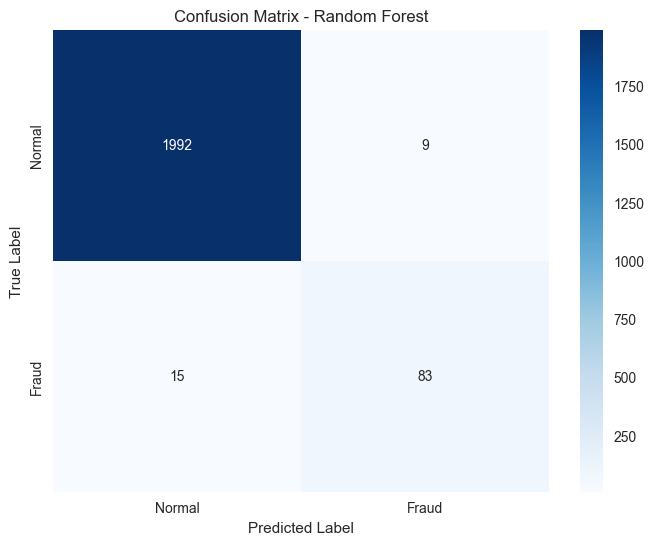


Confusion Matrix:
True Negatives: 1,992
False Positives: 9
False Negatives: 15
True Positives: 83


In [29]:
# Detailed evaluation of the best model
best_predictions = results_smote[best_model_name]['predictions']
best_probabilities = results_smote[best_model_name]['probabilities']

print(f"Detailed Classification Report for {best_model_name}:")
print("=" * 60)
print(classification_report(y_test, best_predictions, target_names=['Normal', 'Fraud']))

# Confusion Matrix
cm = confusion_matrix(y_test, best_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Fraud'], 
            yticklabels=['Normal', 'Fraud'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(f"\nConfusion Matrix:")
print(f"True Negatives: {cm[0,0]:,}")
print(f"False Positives: {cm[0,1]:,}")
print(f"False Negatives: {cm[1,0]:,}")
print(f"True Positives: {cm[1,1]:,}")


In [30]:
# Final optimization summary
print("🎯 OPTIMIZATION SUMMARY:")
print("=" * 60)
print(f"Original Dataset Size: 284,807 transactions")
print(f"Optimized Dataset Size: {len(df):,} transactions")
print(f"Reduction: {(1 - len(df)/284807)*100:.1f}%")
print(f"")
print(f"Training Samples: {X_train_smote.shape[0]:,}")
print(f"Test Samples: {X_test_scaled.shape[0]:,}")
print(f"")
print(f"Total Training Time: {total_time:.2f} seconds")
print(f"Average per Model: {total_time/len(results_smote):.2f} seconds")
print(f"")
print(f"Best Model: {best_model_name}")
print(f"Performance: F1={results_smote[best_model_name]['f1_score']:.4f}, ROC-AUC={results_smote[best_model_name]['roc_auc']:.4f}")
print("=" * 60)
print("✅ Model training completed successfully!")
print("📁 Model files saved and ready for deployment!")


🎯 OPTIMIZATION SUMMARY:
Original Dataset Size: 284,807 transactions
Optimized Dataset Size: 10,492 transactions
Reduction: 96.3%

Training Samples: 15,998
Test Samples: 2,099

Total Training Time: 0.95 seconds
Average per Model: 0.32 seconds

Best Model: Random Forest
Performance: F1=0.8737, ROC-AUC=0.9861
✅ Model training completed successfully!
📁 Model files saved and ready for deployment!


In [31]:
# Model Persistence
model_filename = 'fraud_detection_model.pkl'
scaler_filename = 'fraud_detection_scaler.pkl'

# Save model
with open(model_filename, 'wb') as f:
    pickle.dump(best_model, f)

# Save scaler
with open(scaler_filename, 'wb') as f:
    pickle.dump(scaler, f)

print(f"Model saved as: {model_filename}")
print(f"Scaler saved as: {scaler_filename}")

# Save model metadata
model_metadata = {
    'model_name': best_model_name,
    'model_type': type(best_model).__name__,
    'accuracy': results_smote[best_model_name]['accuracy'],
    'precision': results_smote[best_model_name]['precision'],
    'recall': results_smote[best_model_name]['recall'],
    'f1_score': results_smote[best_model_name]['f1_score'],
    'roc_auc': results_smote[best_model_name]['roc_auc'],
    'feature_names': list(X.columns),
    'training_samples': len(X_train_smote),
    'test_samples': len(X_test)
}

import json
with open('model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=2)

print("Model metadata saved as: model_metadata.json")
print("\nModel Summary:")
print(f"Model: {model_metadata['model_name']}")
print(f"Accuracy: {model_metadata['accuracy']:.4f}")
print(f"F1 Score: {model_metadata['f1_score']:.4f}")
print(f"ROC AUC: {model_metadata['roc_auc']:.4f}")


Model saved as: fraud_detection_model.pkl
Scaler saved as: fraud_detection_scaler.pkl
Model metadata saved as: model_metadata.json

Model Summary:
Model: Random Forest
Accuracy: 0.9886
F1 Score: 0.8737
ROC AUC: 0.9861
